<a href="https://colab.research.google.com/github/Rocco000/OncoVision/blob/main/Scripts/TrainModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import the dataset script**

In [ ]:
from google.colab import drive
drive.mount('/content/drive') #Connect to Google Drive

from google.colab import auth
from googleapiclient.discovery import build

#To authenticate the user that run the script in order to use the correct path
auth.authenticate_user()
drive_service = build('drive', 'v3')

#Get user information
about = drive_service.about().get(fields='user').execute()
user_email = about['user']['emailAddress']
script_owner = False

if user_email =="rocco.iul2000@gmail.com":
  script_owner = True
  #Run the .ipynb file
  %run '/content/drive/MyDrive/Colab Notebooks/DatasetLoader.ipynb'
  %run '/content/drive/MyDrive/Colab Notebooks/ModelArchitecture1.ipynb'
else:
  %run '/content/drive/MyDrive/LinkToOncoVision/DatasetLoader.ipynb'
  %run '/content/drive/MyDrive/LinkToOncoVision/ModelArchitecture1.ipynb'

#Now I can access to the methods of this file
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ",device)

Mounted at /content/drive
Device:  cuda


Link to DagsHub

In [ ]:
import requests
import getpass
import datetime

In [ ]:
#@title Set Environment Variables

#@markdown Enter the repository name for the project:
REPO_NAME= "OncoVision" #@param {type:"string"}

#@markdown Enter the username of your DAGsHub account:
USER_NAME = "Rocco000" #@param {type:"string"}

#@markdown Enter the email for your DAGsHub account:
EMAIL = "rocco.iul2000@gmail.com" #@param {type:"string"}

#@markdown ---

In [ ]:
%pip install -q dagshub

!dagshub login

import dagshub

TOKEN = dagshub.auth.get_token()
!git config --global user.email {EMAIL}
!git config --global user.name {USER_NAME}
%cd /content

!git clone https://dagshub.com/{USER_NAME}/{REPO_NAME}.git

%cd {REPO_NAME}

!pip install mlflow --quiet
import mlflow
import mlflow.pytorch
import os
os.environ["MLFLOW_TRACKING_USERNAME"] = USER_NAME
os.environ["MLFLOW_TRACKING_PASSWORD"] = TOKEN
os.environ["MLFLOW_TRACKING_URI"] = f'https://dagshub.com/{USER_NAME}/{REPO_NAME}.mlflow'

mlflow.set_tracking_uri(os.getenv("MLFLOW_TRACKING_URI"))


def get_experiment_id(name):
  exp = mlflow.get_experiment_by_name(name)
  if exp is None:
    exp_id = mlflow.create_experiment(name)
    return exp_id
  return exp.experiment_id

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.2/84.2 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 15.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 23.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.3/68.3 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.9/54.9 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.5 MB/s eta 0:00:00
                      ❗❗❗ AUTHORIZATION REQUIRED ❗❗❗                      


Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=aa9958b6-9c09-4f72-ad55-4e4d969fb022&client_id=3

Install and Configure DagsHub

In [ ]:
# Install DVC and S3 support
!pip install dvc dvc-s3 &> /dev/null

# Import DVC package - relevant only when working in a Colab environment
import dvc

# Initilize DVC in the local directory
!dvc init &> /dev/null

# Track the changes with git
!git add .dvc .dvcignore
!git commit -m "Initialize DVC"

Configure DVC

In [ ]:
# Set DVC remote storage as 'DAGsHub storage'
!dvc remote add origin s3://dvc
!dvc remote modify origin endpointurl https://dagshub.com/{USER_NAME}/{REPO_NAME}.s3
# General DVC configuration
!dvc remote modify origin --local access_key_id {TOKEN}
!dvc remote modify origin --local secret_access_key {TOKEN}

Script to EVALUATE the model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import torch.nn.functional as F
import numpy as np

def evaluate_model(model, data_loader, decision):
  #Set the model in evaluation mode
  model.eval()
  true_labels = []
  predicted_labels = []

  #In this way we don't computing the gradient
  with torch.no_grad():
    for images, labels in data_loader:
      #Move the image on gpu or cpu. It depends by device variable
      images = images.to(device)
      labels = labels.to(device)

      #Provide the samples to the model
      predictions = model(images)

      #Apply the Softmax activation function. Dim=1 because the output size is [64,2] where the model prediction is in the second column
      predictions = F.softmax(predictions, dim=1)

      #To extract the predicted class with the highest probability for each input sample. 1 to indicate on which dimension apply the max
      _, predictions = torch.max(predictions, 1)

      #print("True labels:")
      #print(labels)
      #print("Predicted labels:")
      #print(predictions)


      #Store the true labels and the predicted labels
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predictions.cpu().numpy())

  #Computing the EVALUATION METRICS
  #.cpu() because it can't convert cuda:0 device type tensor to numpy.
  true_labels = np.array(true_labels)
  predicted_labels = np.array(predicted_labels)

  accuracy = accuracy_score(true_labels, predicted_labels)
  precision = precision_score(true_labels, predicted_labels)
  recall = recall_score(true_labels, predicted_labels)
  f1 = f1_score(true_labels, predicted_labels)

  if decision == 1:
    print("Evaluation metrics in VALIDATION set:")
  else:
    print("Evaluation metrics in TEST set:")
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_precision", precision)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_f1", f1)

  print("Accuracy: ",accuracy, "; Precision: ",precision, "; Recall: ",recall,"; F1: ",f1)

  if decision == 1:
    return accuracy, precision, recall, f1
  else:
    #Computing the confusion metrix (only in TEST STEP)
    cm = confusion_matrix(true_labels, predicted_labels)
    tn, fp, fn, tp = cm.ravel()
    return cm, tp, tn, fp, fn, accuracy, precision, recall, f1

Script to TRAIN the model

In [ ]:
from torchvision.transforms import transforms
import torch
from google.colab.patches import cv2_imshow #because Google Colab doesn't support cv2.imshow(), it causes Jupyter session to crash
import cv2
import torchvision
import torch.nn as nn

#TRAIN STEP
def train_model(model, data_loader, valid_loader, num_epoch, criterion, optimizer):
  print("START TRAINING STEP")
  model.train()
  patience = 0 #We use it to verify if the model not improve
  best_accuracy = 0
  best_precision = 0
  best_recall = 0
  best_f1 = 0
  best_loss = 0
  best_epoch = 0
  loss = 0

  model_state = None #To store the best model status
  optimizer_state = None #To store the best optimizer status

  #To improve the image sharpness. It is random, defined by the parameter P. With sharpness_factor = 1 we only improve the image sharpness
  up_sharpness = torchvision.transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.5)

  #To improve the image contrast. It is random, defined by the parameter P
  up_contrast = torchvision.transforms.RandomAutocontrast(p=0.5)

  for e in range(num_epoch):
    for images, labels in data_loader:
      model.zero_grad() #Set the gradient to zero for each batch

      images = images.to(device)
      labels = labels.to(device)

      #Improve the image sharpness and the image contrast
      images = up_sharpness(images)
      images = up_contrast(images)

      #FORWARD PASS
      predictions = model(images)
      #predictions = predictions.unsqueeze(1)
      #print("Shape dopo unsqueeze: ", predictions.shape)

      #Measure the loss function
      loss = criterion(predictions, labels)

      #print("True label:")
      #print(labels)
      #print("Predicted label:")
      #print(torch.max(F.softmax(predictions, dim=1), 1)[1])

      #BACKWARD PASS
      optimizer.zero_grad() #set the gradient to 0
      loss.backward()
      optimizer.step()

    mlflow.log_metric("train_loss", loss)

    #Test the model on the VALIDATION SET (After trained the model on the batchs)
    print("Start VALIDATION STEP")
    accuracy, precision, recall, f1 = evaluate_model(model, valid_loader, 1)

    #Check if the model has improvement
    if recall == best_recall and accuracy == best_accuracy:
      patience = patience+1
    elif recall>best_recall and accuracy==best_accuracy:
      patience = 0
      best_recall = recall
      best_precision = precision
      best_f1 = f1
      best_loss = loss.item()
      best_epoch = e+1
      model_state = model.state_dict()
      optimizer_state = optimizer.state_dict()
      mlflow.pytorch.log_state_dict(model_state, artifact_path='models')
      mlflow.pytorch.log_state_dict(optimizer_state, artifact_path='optimizers')
      mlflow.log_metric("validation_accuracy", accuracy)
      mlflow.log_metric("validation_precision", precision)
      mlflow.log_metric("validation_recall", recall)
      mlflow.log_metric("validation_f1", f1)
      mlflow.log_metric("best_epoch", best_epoch)
    elif recall == best_recall and accuracy>best_accuracy:
      patience = 0
      best_accuracy = accuracy
      best_precision = precision
      best_f1 = f1
      best_loss = loss.item()
      best_epoch = e+1
      model_state = model.state_dict()
      optimizer_state = optimizer.state_dict()
      mlflow.pytorch.log_state_dict(model_state, artifact_path='models')
      mlflow.pytorch.log_state_dict(optimizer_state, artifact_path='optimizers')
      mlflow.log_metric("validation_accuracy", accuracy)
      mlflow.log_metric("validation_precision", precision)
      mlflow.log_metric("validation_recall", recall)
      mlflow.log_metric("validation_f1", f1)
      mlflow.log_metric("best_epoch", best_epoch)
    elif recall>best_recall and accuracy>best_accuracy:
      patience = 0
      best_accuracy = accuracy
      best_precision = precision
      best_recall = recall
      best_f1 = f1
      best_loss = loss.item()
      best_epoch = e+1
      model_state = model.state_dict()
      optimizer_state = optimizer.state_dict()
      mlflow.pytorch.log_state_dict(model_state, artifact_path='models')
      mlflow.pytorch.log_state_dict(optimizer_state, artifact_path='optimizers')
      mlflow.log_metric("validation_accuracy", accuracy)
      mlflow.log_metric("validation_precision", precision)
      mlflow.log_metric("validation_recall", recall)
      mlflow.log_metric("validation_f1", f1)
      mlflow.log_metric("best_epoch", best_epoch)
    else:
      patience = patience+1

    model.train()
    if patience>32:
      print("Train step stopped at epoch ",e+1," because the model doesn't improve!")
      if model_state is not None and optimizer_state is not None:
        model.load_state_dict(model_state) #Set the model with the best configuration
        optimizer.load_state_dict(optimizer_state)
      break
    print(f"Epoch [{e+1}] Loss: {loss.item():.4f}")

  print("The best model and optimizer configuration was achieved at the ",best_epoch," epoch")
  print("The best accuracy: ",best_accuracy," best recall: ",best_recall, "best loss: ",best_loss)
  print("Finished Training!")
  return model_state, optimizer_state, best_accuracy, best_precision, best_recall, best_f1, best_loss


**TRAIN AND TEST THE MODEL**

Labels:
{'benign': 0, 'malignant': 1}
Number of samples per class ( TRAIN SET ):  {'0': 3822, '1': 3601}
Number of samples per class ( TEST SET ):  {'0': 579, '1': 482}
Number of samples per class ( VALID SET ):  {'0': 1099, '1': 1022}
START TRAINING STEP
Start VALIDATION STEP
Evaluation metrics in VALIDATION set:
Accuracy:  0.8095238095238095 ; Precision:  0.8418141592920354 ; Recall:  0.7446183953033269 ; F1:  0.7902388369678089
Epoch [1] Loss: 0.4707
Start VALIDATION STEP
Evaluation metrics in VALIDATION set:
Accuracy:  0.8576143328618576 ; Precision:  0.8202846975088968 ; Recall:  0.9021526418786693 ; F1:  0.8592730661696178
Epoch [2] Loss: 0.2725
Start VALIDATION STEP
Evaluation metrics in VALIDATION set:
Accuracy:  0.8708156529938709 ; Precision:  0.9348837209302325 ; Recall:  0.786692759295499 ; F1:  0.8544102019128587
Epoch [3] Loss: 0.2054
Start VALIDATION STEP
Evaluation metrics in VALIDATION set:
Accuracy:  0.8816595945308816 ; Precision:  0.8913705583756345 ; Recall:  0.859

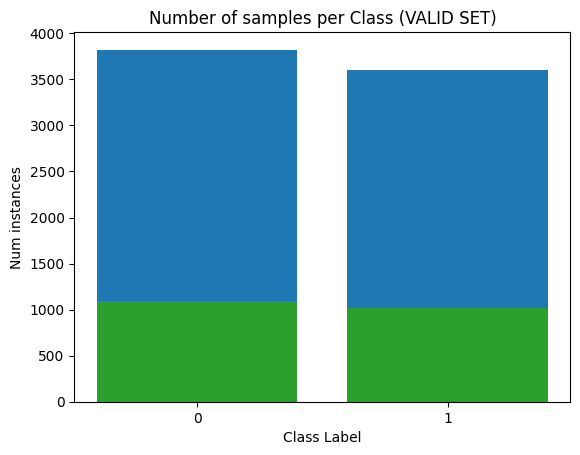

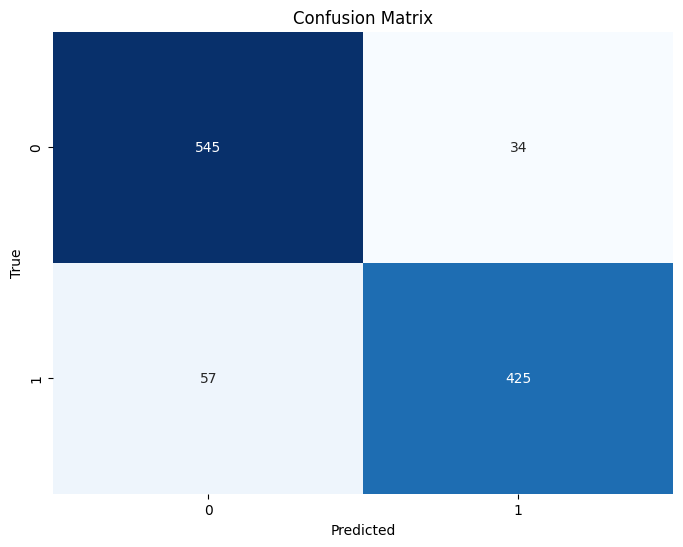

TP:  425  TN:  545  FP:  34  FN: 57


In [ ]:
import csv
import seaborn as sns
import matplotlib.pyplot as plt

path = ""
if script_owner:
  path = "/content/drive/MyDrive/SE4AI/Data/Datasets/Dataset1/"
else:
  path = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Data/Datasets/Dataset1/"


#Get the dataloader for each set
train_loader, valid_loader, test_loader = get_dataset(path,percent_train=0.7, percent_valid=0.2, batch_size=64)

#Plot the samples for each set
plot_samples(train_loader, "TRAIN SET")
plot_samples(test_loader, "TEST SET")
plot_samples(valid_loader, "VALID SET")

#Define the CNN
model = ConvModel1().to(device)

#Define the loss function -> CrossEntropyLoss because i build a cnn for binary classification using two neurons in the output layer that represent the corresponding class
#This loss already apply the Softmax activation function in order to ensure that the probabilities sum up to 1.
class_weights = torch.tensor([0.4, 0.6])
criterion = nn.CrossEntropyLoss(weight=class_weights)

#Define the optimizer
optimizer = torch.optim.Adam(params=model.parameters(), lr= 0.001)

#Start to track the model with MlFlow
mlflow_id = get_experiment_id("mlflow model trained on dataset1 NO CLEANED")

confusion=tp=tn=fp=fn=acc=pre=rec=f1 = 0

with mlflow.start_run(experiment_id=mlflow_id):
  mlflow.pytorch.log_state_dict(model.state_dict(), artifact_path='models')
  mlflow.pytorch.log_state_dict(optimizer.state_dict(), artifact_path='optimizers')

  #Start the train step
  best_model_configuration, best_optimizer_configuration, acc, pre, rec, f1, loss = train_model(model=model, data_loader=train_loader, valid_loader=valid_loader, num_epoch= 64, criterion=criterion, optimizer=optimizer)

  path_parameters = ""
  path_op_parameters = ""
  path_csv = ""

  #Store the best configurations
  if script_owner:
    path_parameters = "/content/drive/MyDrive/SE4AI/Model/EvaluationOnDB1NoCleaned/model_parameters.pth"
    path_op_parameters = "/content/drive/MyDrive/SE4AI/Model/EvaluationOnDB1NoCleaned/optimizer_parameters.pth"
    path_csv = "/content/drive/MyDrive/SE4AI/Model/EvaluationOnDB1NoCleaned/evaluation_metrics_VALIDATION.csv"
  else:
    path_parameters = "/content/drive/MyDrive/LinkToOncoVision//SE4AI/Model/EvaluationOnDB1NoCleaned/model_parameters.pth"
    path_op_parameters = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationOnDB1NoCleaned/optimizer_parameters.pth"
    path_csv = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationOnDB1NoCleaned/evaluation_metrics_VALIDATION.csv"

  torch.save(best_model_configuration, path_parameters)
  torch.save(best_optimizer_configuration, path_op_parameters)

  with open(path_csv, "w", newline="") as csvfile:
      writer = csv.writer(csvfile)
      writer.writerow(["Accuracy","Precision","Recall","F1-Score", "Loss"])
      writer.writerow([acc,pre,rec,f1,loss])

  model.load_state_dict(best_model_configuration) #Load the best model configuration
  model.to(device)

  confusion, tp, tn, fp, fn, acc, pre, rec, f1 = evaluate_model(model, test_loader, 0)

!git commit -a -m "added mlflow logging"
!git push origin main

#Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

#Save the confusion metrix
path_csv = ""
if script_owner:
  plt.savefig('/content/drive/MyDrive/SE4AI/Model/EvaluationOnDB1NoCleaned/confusion_matrix.png')
  path_csv = "/content/drive/MyDrive/SE4AI/Model/EvaluationOnDB1NoCleaned/evaluation_metrics_TEST.csv"
else:
  plt.savefig('/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationOnDB1NoCleaned/confusion_matrix.png')
  path_csv = "/content/drive/MyDrive/LinkToOncoVision/SE4AI/Model/EvaluationOnDB1NoCleaned/evaluation_metrics_TEST.csv"

plt.show()


print("TP: ",tp," TN: ",tn," FP: ",fp," FN:",fn)

with open(path_csv, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Accuracy","Precision","Recall","F1-Score"])
    writer.writerow([acc,pre,rec,f1,loss])